In [68]:
import os
from os import listdir
from os.path import isfile, join
import copy
import re
import pandas as pd
from uuid import uuid4
from tqdm import tqdm
import glob
import requests
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse
from scipy.sparse.linalg import svds
import time
import numpy as np
import matplotlib.pyplot as plt

In [69]:
input_folder = 'raw_texts'
output_folder = 'lemmatized_texts'

In [70]:
try:
    os.mkdir(input_folder)
except:
    pass

try:
    os.mkdir(output_folder)
except:
    pass

In [71]:
pos_dict = {'PROPN': 'person1', 'PRON': 'pron1', 'NUM': 'ordinal1'}

## Вытаскиваем заголовки-текст из вики

In [72]:
def parse_kabyle_wiki():
    link_pref = 'https://kab.wikipedia.org'
    cur_link = '/w/index.php?title=Uslig:Toutes_les_pages&from=Taz'
    session = requests.session()
    while True:
        current_page = link_pref + cur_link
        print(current_page)
        response = session.get(current_page)
        soup = BeautifulSoup(response.text, 'html.parser')

        pages = soup.find('ul', {'class': 'mw-allpages-chunk'}).find_all('li')
        for page in pages:
            try:
                page_url = link_pref + page.find('a').get('href')

                page_soup = BeautifulSoup(session.get(page_url).text, 'html.parser')
                page_title = page_soup.find('h1')
                if page_title is None:
                    print(page_url)
                    continue
                page_title = page_title.text.replace('"', '')
                page_content = page_soup.find_all('p')  # собираю только абзацы текста

                page_text = ''
                for el in page_content:
                    page_text += el.text.strip() + ' '
                open(f'{input_folder}/{page_title}.txt', 'w', encoding='utf-8').write(page_text)
            except Exception as exc:
                print(exc)

        next_page_links = soup.find_all('a', {'title': 'Uslig:Toutes les pages'})
        if len(next_page_links) < 4:
            break
        cur_link = next_page_links[1].get('href')


In [73]:
# parse_kabyle_wiki()

In [74]:
onlyfiles = [f for f in listdir(input_folder) if isfile(join(input_folder, f))]
onlyfiles

['A Game of Thrones.txt',
 'A Vava Inuva.txt',
 'Abaggus n izunyuren.txt',
 'Abaggus n Kuiper.txt',
 'Abaggus n umanar.txt',
 'Abagu Afarsi.txt',
 'Abagu n Miksik.txt',
 'Abalessa.txt',
 'Abanan.txt',
 'Abanɣu.txt',
 'Abareɣ azeggaɣ.txt',
 'Abareɣ.txt',
 'ABBA.txt',
 'Abbaɣ.txt',
 'Abbu.txt',
 'Abbé Pierre.txt',
 'Abelkim.txt',
 'Abellau.txt',
 'Abellez.txt',
 'Abender n tifri.txt',
 'Abenra.txt',
 'Abenǧil.txt',
 'Aberdeɣyul (tawsit).txt',
 'Aberkan.txt',
 'Aberni.txt',
 'Aberru.txt',
 'Aberzegzaw.txt',
 'Aberɣeggal.txt',
 'Abexsis asemmam.txt',
 'Abeṛṛay n tẓegwa.txt',
 'Abeṛṛay.txt',
 'Abidjan.txt',
 'Ablaɣ.txt',
 'Ableɣ.txt',
 'Abraham Ortelius.txt',
 'Abranis.txt',
 'Abrawtem.txt',
 'Abruri.txt',
 'Absis.txt',
 'Abu Lḥasan.txt',
 'Abu Nuwas.txt',
 'Abu Ɛabdu Allah idrisi.txt',
 'Abu Ḍabi.txt',
 'Abucenbel amaziɣ.txt',
 'Abuferriw.txt',
 'Abuja.txt',
 'Abulekkaz.txt',
 'Abuneqqaṛ.txt',
 'Abunsay.txt',
 'Aburjij.txt',
 'Aburɣes.txt',
 'Abusum.txt',
 'Abxazya.txt',
 'Abyannu.txt',
 '

 ## Чистим от символов, переводим в нижний регистр, удаляем стоп-слова

In [75]:
# Заплатка: Это стоп-слова (предлоги и тп). Позже я их буду убирать
stop_words = pd.read_csv("stopwords.txt", header=None)[0] 

# Заплатка: для удаления слов других языков (встречались на wiki) 
# В самом конце я вручную отсматривала полученные лемматизатором слова и смотрела, каких быть не должно - их символы вписывала сюда (но если таких же символов не может быть в моем языке) 
other_lang_symbols = 'ﻥﺥﺣﻠﺐأبجدﻩوزحطيكلمنسعفصقرشتثخذضظغﻙָֹּअउगतदपबभमयरवसहाी्ංකජතදනපමයරලවශසහ්ාිීׁאבגדהוזחטיכלםמןנסעפうえかがぎしぞどなのばふまめよんァアィイカガギクグサザスソダットドナニパフボマミモラリルレロンヴー一万为京人仮例刻北华名和国在城基外大女子孔少川巨市帶康性成撃旅日景本条来東栽武汉江法波津漢為男盆端華葉西言語連進都長长限魔기남대성연재ﬥﯾﷺﺍﺏﺔﺕﺙﺝﺠﺡﺩﺫﺭﺯﺱﺵﺹﺽﻁﻅﻉﻍﻑﻕﻝﻟﻡﻤﻬﻭﻮצקרשת،؛ـهَِّ٪ٮۦܐܕܘܙܝܟܢܣܥܪܫܬⲁⲉⲏⲓⲙⲛⲟⲡⲣⲥⲧⲩⲫⲭⴰⴱⴳⴴⴵⴶⴷⴹⴻⴼⴽⴾⴿⵀⵂⵃⵄⵅⵇⵈⵉⵊⵋⵌⵍⵎⵏⵒⵓⵔⵕⵖⵗⵙⵚⵛⵜⵟⵡⵢⵣⵥ𐌰𐌴𐌷𐌸𐌹𐌺𐍂𐍃𐍉𐤀𐤁𐤃𐤆𐤇𐤋𐤌𐤍𐤎𐤏𐤐𐤑𐤒𐤓𐤕ëабвгдежзийклмнопрстуфхцчшщъыьюяë'

In [76]:
def clean_article(article):
    cleaned = copy.deepcopy(article).lower()

    cleaned = cleaned.replace("ʷ", "w")
    cleaned = cleaned.replace("!", ".").replace("?", ".")
    cleaned = cleaned.replace("”", "")

    # Заплатка: удаляем числа и специальные символы, меняем доп латиницу на обычную
    # тоже вручную отсматривала плохие символы на выходе
    pattern_order = '[]*×∼,.;:@#№$%^&+=<>()\'ˈ‘’‚“”„´`ʼ′″"«»‹›©§/\\°↑→|²³⁴~{}£¥¨±µ·ß-‑–—↦⇒∅−∞⊙⋅⌂◼◾☆♀♂♥✚✝⟹ ⵧⵯ《》ʁøþœǝǳɐɑɔɕəʕʰʲʾʿˌːˠˤ̣̪̯̲̃̄̇͡αβγδεζηθ‟†•…⁄€æλμνξπρςστυχψωύђєљњћџґɬɲɾʃʊʒʔέκοφԑաեիլնոտրևỿἑἤῥ⁡﻿👌'
    extended_latin = {'Ḁḁåάåâàāâáãäăǎἀ': 'a', 'ḂḃḄḅḆḇ': 'b', 'Ḉḉçčć': 'c', 'ḊḋḌḍḎḏḐḑḒḓďđ': 'd', 'ḔḕḖḗḘḙḚḛḜḝěèéêēĕẹ': 'e', 'Ḟḟ': 'f',
                      'Ḡḡǧģğǥɡ': 'g', 'ḢḣḤḥḦḧḨḩḪḫĥ': 'h', 'ḬḭḮḯíïіїїǐìîīįıἶῖỉ': 'i', 'ḰḱḲḳḴḵ': 'k', 'ḶḷḸḹḺḻḼḽίιł': 'l', 'ḾḿṀṁṂṃ': 'm',
                      'ṄṅṆṇṈṉṊṋñńňή': 'n', 'ṌṍṎṏṐṑṒṓôόòóõöǒộὁō': 'o', 'ṔṕṖṗ': 'p', 'ṘṙṚṛṜṝṞṟř': 'r', 'ṠṡṢṣṣṤṥṦṧṨṩśşšș': 's',
                      'ṪṫṬṭṮṯṰṱţț': 't', 'ṲṳṴṵṶṷṸṹṺṻůùúûüūŭ': 'u', 'ṼṽṾṿ': 'v', 'ẀẁẂẃẄẅẆẇẈẉ': 'w', 'ẊẋẌẍ': 'x', 'Ẏẏý': 'y',
                      'ẐẑẒẓẔẕžż': 'z'}
    for keys in extended_latin.keys():
        for letter in keys:
            cleaned = cleaned.replace(letter, extended_latin[keys])

    num_symbols = '1234567890'
    for symbol in pattern_order:
        cleaned = cleaned.replace(symbol, " ")

    while '  ' in cleaned:
        cleaned = cleaned.replace("  ", " ")

    cleaned = cleaned.split()

    # replace pronouns with 'PRON'
    file_pron = open('pronouns.txt', 'r', encoding='utf-8').read().split('\n')
    file_numerals = open('numerals.txt', 'r', encoding='utf-8').read().split('\n')
    previous = ''

    for word_ind in range(len(cleaned)):
        # Заплатка: проверка, принадлежит ли слово моему языку
        # Note: тут лучше было бы подумать над более умной проверкой
        s_other_lang = False
        for c in cleaned[word_ind]:
            if c in other_lang_symbols:
                cleaned[word_ind] = ''
                s_other_lang = True
                break
        if s_other_lang:
            continue

        if cleaned[word_ind] in stop_words:
            cleaned[word_ind] = ''
        elif cleaned[word_ind] in file_pron:
            cleaned[word_ind] = pos_dict['PRON']
        elif cleaned[word_ind].isnumeric() or cleaned[word_ind] in file_numerals:
            cleaned[word_ind] = pos_dict['NUM']
        elif all([x.isnumeric() for x in cleaned[word_ind].split('-')]):  # pattern is "NUM-NUM"
            cleaned[word_ind] = pos_dict['NUM']
        elif '-' in cleaned[word_ind]:
            attempt = cleaned[word_ind].split('-')
            for i_part in range(len(attempt)):
                if attempt[i_part] in file_pron:
                    attempt[i_part] = pos_dict['PRON']
                elif attempt[i_part].isnumeric() or attempt[i_part] in file_numerals:
                    attempt[i_part] = pos_dict['NUM']
            cleaned[word_ind] = ' '.join(attempt)
        else:
            for s in num_symbols:
                cleaned[word_ind] = cleaned[word_ind].replace(s, f" {pos_dict['NUM']} ")
        if word_ind > 0 and cleaned[word_ind] == pos_dict['NUM'] and cleaned[word_ind - 1] in ['wis', 'tis']:
            cleaned[word_ind - 1] = ''
    for val in pos_dict.values():
        while f"{val} {val}" in cleaned:
            cleaned = cleaned.replace(f"{val} {val}", f"{val}")
    while '  ' in cleaned:
        cleaned = cleaned.replace('  ', ' ')
    cleaned = ' '.join(cleaned)

    return cleaned

## Лемматизация (не до конца проверенная)

Вспомогательный ресурс: [github](https://github.com/YazidIflis/KabyleNLP), откуда взяты лемматизация глаголов и определение частей речи


In [77]:
def amasal(azrir):
    amasal = ''
    for i in azrir:
        if i == 'e':
            amasal = amasal + 'e'
        else:
            amasal = amasal + 'c'
    return amasal


def sekyed_asekkil(asekkil, tighra):
    yella = False
    for i in tighra:
        if asekkil == i:
            yella = True

    return yella


def check_converted(converted_verb, vowels):
    if len(converted_verb) >= 3:
        if not (sekyed_asekkil(converted_verb[len(converted_verb) - 2:len(converted_verb) - 1], vowels) or
                sekyed_asekkil(converted_verb[len(converted_verb) - 1:len(converted_verb)], vowels)):

            if (converted_verb[len(converted_verb) - 3:len(converted_verb) - 2] != 'e' and
                    converted_verb[len(converted_verb) - 2:len(converted_verb) - 1] !=
                    converted_verb[len(converted_verb) - 1:len(converted_verb)]):
                converted_verb = (converted_verb[:len(converted_verb) - 1] + 'e' +
                                  converted_verb[len(converted_verb) - 1:len(converted_verb)])

    if (len(converted_verb) == 2) and (converted_verb[0] not in vowels) and (converted_verb[1] not in vowels):
        if (converted_verb[0] not in ['ɣ', 'm', 'z', 's', 'g', 'd', 'ẓ']):
            converted_verb = 'e' + converted_verb[len(converted_verb) - 2:len(converted_verb)]
        else:
            converted_verb = converted_verb[0] + 'e' + converted_verb[1]
    return converted_verb


def handle_e_future(converted_verb):
    # обработка случаев смещения e
    if amasal(converted_verb) == 'cecec':
        converted_verb = converted_verb[0] + converted_verb[2:len(converted_verb)]
    if amasal(converted_verb) == 'ccccecec':
        converted_verb = converted_verb[:4] + converted_verb[5:len(converted_verb)]
    if amasal(converted_verb) == 'cccecec':
        converted_verb = converted_verb[:3] + converted_verb[4:len(converted_verb)]
    if amasal(converted_verb) == 'ccecec':
        converted_verb = converted_verb[:1] + 'e' + converted_verb[1:2] + converted_verb[3:len(converted_verb)]
    return converted_verb


def handle_e_future_second(converted_verb):
    # обработка случаев смещения e
    if amasal(converted_verb) == 'cecec':
        converted_verb = converted_verb[0] + converted_verb[2:len(converted_verb)]
    if amasal(converted_verb) == 'ccccecec':
        converted_verb = converted_verb[:4] + converted_verb[5:len(converted_verb)]
    if amasal(converted_verb) == 'cccecec':
        converted_verb = converted_verb[:3] + converted_verb[4:len(converted_verb)]
    if amasal(converted_verb) == 'ccecec':
        converted_verb = (converted_verb[:1] + 'e' + converted_verb[1:2] +
                          converted_verb[len(converted_verb) - 3:len(converted_verb)])
    if amasal(converted_verb) == 'ccececec':
        converted_verb = converted_verb[0:4] + converted_verb[len(converted_verb) - 3:len(converted_verb)]
    return converted_verb


def lemmatize_verb(verb: str):
    vowels = ['a', 'e', 'i', 'u']  # гласные
    verb_len = len(verb)
    converted_verb = ""

    # лемматизация будущего (аорист?)
    if verb.endswith('iɣ') or verb.endswith('uɣ'):
        converted_verb = verb[:verb_len - 2]
        converted_verb = handle_e_future(converted_verb)
    elif verb.endswith('eɣ'):
        converted_verb = verb[:verb_len - 2]
        converted_len = len(converted_verb)
        if converted_len >= 2 and converted_verb[-2] not in vowels:  #  Если предпоследняя буква не гласная
            if converted_verb[-2] != converted_verb[-1]:
                # Если последние две буквы не совпадают
                converted_verb = converted_verb[:converted_len - 1] + 'e' + converted_verb[converted_len - 1]
            elif converted_len <= 2:  # если больше двух согласных
                converted_verb = 'e' + converted_verb[converted_len - 2:converted_len]
        converted_verb = handle_e_future(converted_verb)

    elif (verb.endswith('iḍ') or verb.endswith('uḍ')) and ((verb.startswith('ta') or verb.startswith('te'))):
        if verb.startswith('ta'):
            converted_verb = verb[1:verb_len - 3]
        elif verb.startswith('te'):
            converted_verb = verb[2:verb_len - 3]
        converted_verb = handle_e_future_second(converted_verb)

    elif verb.endswith('iḍ') and verb.startswith('t'):
        converted_verb = verb[1: verb_len - 3]
        converted_len = len(converted_verb)
        if converted_len <= 2:  # если больше двух согласных
            converted_verb = 'e' + converted_verb[converted_len - 2:converted_len]
        converted_verb = handle_e_future_second(converted_verb)

    elif verb.endswith('eḍ') and verb.startswith('te'):
        converted_verb = verb[2:verb_len - 3]
        converted_len = len(converted_verb)
        if converted_len <= 2:  # если больше двух согласных
            converted_verb = 'e' + converted_verb[converted_len - 2:converted_len]
        converted_verb = handle_e_future_second(converted_verb)

    elif verb.startswith('ta'):
        converted_verb = verb[1:verb_len - 4]
        converted_len = len(converted_verb)
        if converted_len <= 2:  # если больше двух согласных
            converted_verb = 'e' + converted_verb[converted_len - 2:converted_len]
        elif converted_verb[converted_len - 2] not in vowels:  #  Если предпоследняя буква не гласная
            if (converted_verb[converted_len - 2] != converted_verb[converted_len - 1]):
                # Если последние две буквы не совпадают
                converted_verb = converted_verb[:converted_len - 1] + 'e' + converted_verb[converted_len - 1]

        converted_verb = handle_e_future_second(converted_verb)
    elif verb.startswith('te'):
        converted_verb = verb[2:verb_len - 4]
        converted_len = len(converted_verb)
        if converted_len <= 2:  # если больше двух согласных
            converted_verb = 'e' + converted_verb[converted_len - 2:converted_len]
        elif converted_verb[converted_len - 2] not in vowels:  #  Если предпоследняя буква не гласная
            if (converted_verb[converted_len - 2] != converted_verb[converted_len - 1]):
                # Если последние две буквы не совпадают
                converted_verb = converted_verb[:converted_len - 1] + 'e' + converted_verb[converted_len - 1]

        converted_verb = handle_e_future_second(converted_verb)
    elif (verb.startswith('i') or (verb.startswith('t') and not verb.startswith('te')) or
          verb.startswith('ti') or verb.startswith('ta') or verb.startswith('yi')
          or verb.startswith('ya') or verb.startswith('yu')):
        converted_verb = verb[1:verb_len]
        if (len(converted_verb) <= 2 and len(converted_verb) > 0 and converted_verb[0] not in vowels
                and converted_verb[len(converted_verb) - 1] not in vowels):
            converted_verb = 'e' + converted_verb[len(converted_verb) - 2:len(converted_verb)]

    elif verb.startswith('ye') or verb.startswith('te'):
        converted_verb = verb[2:verb_len]
        if (len(converted_verb) <= 2 and len(converted_verb) > 0 and converted_verb[0] not in vowels
                and converted_verb[len(converted_verb) - 1] not in vowels):
            converted_verb = 'e' + converted_verb[len(converted_verb) - 2:len(converted_verb)]
    elif (verb.endswith('im') or verb.endswith('imt')) and (verb.startswith('ti') or verb.startswith('ta')):
        if verb.endswith('m'):
            converted_verb = verb[1:len(verb) - 1]
        else:
            converted_verb = verb[1:len(verb) - 2]

        if (len(converted_verb) == 2) and converted_verb[0] not in vowels:
            converted_verb = 'e' + converted_verb[len(converted_verb) - 2:len(converted_verb)]

        converted_verb = handle_e_future_second(converted_verb)
    elif (verb.endswith('em') or verb.endswith('emt')) and verb.startswith('ta'):
        if verb.endswith('m'):
            converted_verb = verb[1:len(verb) - 2]
        else:
            converted_verb = verb[1:len(verb) - 3]

        if (len(converted_verb) == 2) and converted_verb[0] not in vowels:
            converted_verb = 'e' + converted_verb[len(converted_verb) - 2:len(converted_verb)]

        converted_verb = handle_e_future_second(converted_verb)
    elif (verb.endswith('em') or verb.endswith('emt')) and verb.startswith('ti'):
        if verb.endswith('m'):
            converted_verb = verb[1:len(verb) - 2]
        else:
            converted_verb = verb[1:len(verb) - 3]

        if (len(converted_verb) == 2) and converted_verb[0] not in vowels:
            converted_verb = 'e' + converted_verb[len(converted_verb) - 2:len(converted_verb)]

        converted_verb = handle_e_future_second(converted_verb)
    elif (verb.endswith('em') or verb.endswith('emt')) and verb.startswith('tu'):
        if verb.endswith('m'):
            converted_verb = verb[1:len(verb) - 2]
        else:
            converted_verb = verb[1:len(verb) - 3]

        if (len(converted_verb) == 2) and converted_verb[0] not in vowels:
            converted_verb = 'e' + converted_verb[len(converted_verb) - 2:len(converted_verb)]

        converted_verb = handle_e_future_second(converted_verb)
    elif (verb.endswith('em') or verb.endswith('emt')) and verb.startswith('te'):
        if verb.endswith('m'):
            converted_verb = verb[2:len(verb) - 2]
        else:
            converted_verb = verb[2:len(verb) - 3]

        if (len(converted_verb) == 2) and converted_verb[0] not in vowels:
            converted_verb = 'e' + converted_verb[len(converted_verb) - 2:len(converted_verb)]

        converted_verb = handle_e_future_second(converted_verb)
    elif (verb.endswith('em') or verb.endswith('emt')) and verb.startswith('t'):
        if verb.endswith('m'):
            converted_verb = verb[1:len(verb) - 2]
        else:
            converted_verb = verb[1:len(verb) - 3]
        if (len(converted_verb) == 2) and converted_verb[0] not in vowels:
            converted_verb = 'e' + converted_verb[len(converted_verb) - 2:len(converted_verb)]

        converted_verb = handle_e_future_second(converted_verb)
    # лемматизировать аорист будущего времени (мужской и женский род множественного числа)
    elif verb.endswith('emt') or verb.endswith('ent'):
        converted_verb = verb[:len(verb) - 3]
        converted_verb = check_converted(converted_verb, vowels)
    elif verb.endswith('mt') or verb.endswith('nt'):
        converted_verb = verb[:len(verb) - 2]
        converted_verb = check_converted(converted_verb, vowels)
    elif verb.endswith('et') or verb.endswith('en'):
        converted_verb = verb[:len(verb) - 2]
        converted_verb = check_converted(converted_verb, vowels)
    elif verb.endswith('t') or verb.endswith('n'):
        converted_verb = verb[:len(verb) - 1]
        converted_verb = check_converted(converted_verb, vowels)

    return converted_verb

In [78]:
# NOUNS+ADJECTIVES LEMMATISATION

def make_noun_masculine(word: str) -> str:  # change gender if needed
    if word.startswith('t') and word.endswith('t'):
        if len(word) < 3:
            print(word)
        word = word[1:-1]
        if len(word) == 0:
            return word
        if word[0] not in 'aiue':
            word = 'a' + word
        if word.startswith('e'):
            word = 'a' + word[1:]
    elif word.startswith('as'):  # delete article
        word = word[2:]
    return word


def make_noun_free_state(word: str) -> str:
    if word.startswith('w'):
        word = word[1:]
        if len(word) == 0:
            return word
        elif word[0] not in 'aiue':
            word = 'a' + word
        elif word[0] == 'e':
            word = 'a' + word[1:]
    elif word.startswith('y'):
        word = word[1:]
        if len(word) == 0:
            return word
        if word[0] not in 'aiue':
            word = 'i' + word
        elif word[0] == 'e':
            word = 'i' + word[1:]
    elif word.startswith('u'):
        word = 'a' + word[1:]
    return word


def make_noun_singular(word: str) -> str:
    if not word.startswith('i'):
        if word[-3:] in ['wan', 'wen']:
            word = word[:-3]
        elif word[-2:] in ['an', 'en']:
            word = word[:-2]
        return word

    if 'u' in word:  # patterns i*u*→i*a* & i*u*en→i*a*
        word = 'a' + word[1:]  # i*→a*
        word = re.sub('u', 'a', word, 1)
        if word[-3:] in ['wan', 'wen']:
            word = word[:-3]
        elif word[-2:] in ['an', 'en']:
            word = word[:-2]
    else:
        if word[-2:] == 'an':  # pattern i*an→i*i
            word = word[:-2]
        elif word[-2:] == 'en':  # pattern i*en→a*
            word = 'a' + word[1:-2]
    return word


def lemmatize_nouns_and_adjectives(word: str):
    word = make_noun_masculine(word)
    word = make_noun_free_state(word)
    word = make_noun_singular(word)
    return word

In [79]:
def lemmatize_text(input_file, output_file):
    text = open(input_file, encoding='utf-8').read()
    text = clean_article(text)

    words_list = text.split()
    # nounprefixes1 = {'a', 'i'}
    # nounprefixes2 = {'ta', 'ti'}
    # nounsuffixes = {'an', 'en', 'in'}
    # verbsprefixes = {'ttwa', 'tettwa', 'tettu', 'ttu'}
    precedent = ''

    for ind in range(len(words_list)):
        word = words_list[ind]

        if word in pos_dict.values() or len(word) <= 2:
            precedent = word
            continue

        # ette ligne c'est pour chercher les noms et adjectifs commençant par a, i, te et ti, et ta. ou bien les noms ayant subis un état d'annexion
        if (word.startswith('tu') or (word.startswith('ta') or word.startswith('te') or word.startswith(
                'ti')) and precedent != 'ad') or (((word.startswith('a') or word.startswith(
            'i') or word.startswith('u')) and (not word.endswith('i') and not word.endswith(
            'u') and not word.endswith('a') and len(word) <= 3)) or ((word.startswith(
            'yi') or word.startswith('u') or word.startswith('a') or word.startswith('i')) and len(
            word) > 3 and precedent != 'ad')):
            words_list[ind] = lemmatize_nouns_and_adjectives(word)
        else:
            if (precedent == 'ad' or precedent == 'd' or precedent == 't' or precedent == 'id') or (
                    word.startswith('tt') or word.startswith('ye') or word.startswith(
                'ye') or word.startswith('te') or word.endswith('an') or word.endswith('ant') or (
                            word.endswith('iɣ') or word.endswith('in'))):
                words_list[ind] = lemmatize_verb(word)

        precedent = word

    open(output_file, 'w', encoding='utf-8').write(' '.join(words_list))

## Creating corpus

In [80]:
def make_corpus(input_path, output_file_path):
    file_list = sorted(glob.glob(input_path + '/*'))
    with open(output_file_path, 'w', encoding='utf-8') as output_file:
        for file in tqdm(file_list):
            with open(file, 'r', encoding='utf-8') as input_file:
                output_file.write(input_file.read().replace('\n', ' '))
                output_file.write('\n')

In [81]:
# make_corpus(input_folder, 'kabyle_corpus.txt')

In [82]:
def lemmatize_single_texts():
    for cur_file in onlyfiles:
        lemmatize_text(f'{input_folder}/{cur_file}', f'{output_folder}/{cur_file}')

In [83]:
lemmatize_single_texts()

In [84]:
make_corpus(f'{output_folder}', 'pre_lemmatized_corpus.txt')

100%|██████████| 6377/6377 [00:25<00:00, 250.52it/s] 


In [85]:
# lemmatize_text('kabyle_corpus.txt', 'pre_lemmatized_corpus.txt')

> Исходные объединенные тексты в файле kabyle_corpus
> Лемматизированные тексты в файле pre_lemmatized_corpus


## TFIDF matrix

In [86]:
def make_table_and_dict(corpus_path, min_df, max_df, token_pattern=None, use_idf=True):
    with open(corpus_path, 'r', encoding='utf-8') as corpus_file:
        if token_pattern:
            vectorizer = TfidfVectorizer(analyzer='word', min_df=min_df, token_pattern=token_pattern, use_idf=use_idf)
        else:
            vectorizer = TfidfVectorizer(analyzer='word', min_df=min_df)
        data_vectorized = vectorizer.fit_transform(corpus_file)
    return data_vectorized, vectorizer.get_feature_names_out(), vectorizer.idf_

In [87]:
kabyle_data_vectorized, kabyle_dictionary, idfs = make_table_and_dict('pre_lemmatized_corpus.txt', 5, 8)
scipy.sparse.save_npz('sparse_matrix_after_tfidf.npz', kabyle_data_vectorized)

In [88]:
print(kabyle_dictionary)

['aacn' 'ab' 'ababar' ... 'ɣzer' 'ɣɣar' 'ɣɣaren']


In [89]:
def apply_svd(W, k, output_folder):
    '''
    W - matrix texts x words
    k - the rank of the SVD, must be less than any dimension of W
    '''
    #Apply the SVD function
    u, sigma, vt = svds(W, k)

    #The function does not garantee, that the order of the singular values is descending
    #So, we need to dreate it by hand
    descending_order_of_inds = np.flip(np.argsort(sigma))
    u = u[:, descending_order_of_inds]
    vt = vt[descending_order_of_inds]
    sigma = sigma[descending_order_of_inds]

    #Checking that sizes are ok
    assert sigma.shape == (k,)
    assert vt.shape == (k, W.shape[1])
    assert u.shape == (W.shape[0], k)

    #Now, we'll save all the matrixes in folder (just in case)
    with open(output_folder + '/' + str(k) + '_sigma_vt.npy', 'wb') as f:
        np.save(f, np.dot(np.diag(sigma), vt).T)
    with open(output_folder + '/' + str(k) + '_sigma.npy', 'wb') as f:
        np.save(f, sigma)
    with open(output_folder + '/' + str(k) + '_u.npy', 'wb') as f:
        np.save(f, u)
    with open(output_folder + '/' + str(k) + '_vt.npy', 'wb') as f:
        np.save(f, vt)
    return np.dot(np.diag(sigma), vt).T

In [90]:
try:
    os.mkdir('content')
except:
    pass
vv = apply_svd(kabyle_data_vectorized, 2, 'content')

In [91]:
vv.shape

(6367, 2)

In [92]:
np.save('maxtrix_after_svd.npy', vv)

In [93]:
def create_dictionary(words_list, vv, output_file):
    dictionary = {}
    for word, vector in zip(words_list, vv):
        dictionary[word] = vector
    np.save(output_file, dictionary)
    return dictionary

In [94]:
dictionary = create_dictionary(kabyle_dictionary, vv, 'kabyle_dummy_dictionary.npy')

In [95]:
for word in dictionary:
    print(f"'{word}': {dictionary[word]}")

'aacn': [-0.1236174  -0.13592168]
'ab': [-0.00468231 -0.00299885]
'ababar': [-0.03631424 -0.01391168]
'ababat': [-0.02810485 -0.02470475]
'abadiy': [-0.0040063  -0.00330036]
'abadrar': [-0.02554126 -0.0079027 ]
'abadu': [-0.01588779 -0.01455425]
'abaggus': [-0.01768722 -0.0127107 ]
'abagu': [-0.04985757 -0.02823952]
'abalal': [-0.00843981 -0.00687887]
'aban': [-0.01751268 -0.01408589]
'abaraz': [-0.00343715 -0.00265127]
'abaraɣ': [-0.01598656 -0.0129185 ]
'abareɣ': [-0.01664568 -0.01451954]
'abareɣs': [-0.09804779 -0.08500611]
'abarɣas': [-0.04819887 -0.03883   ]
'abaski': [-0.01678112 -0.01490224]
'abaskiy': [-0.02653043 -0.02466042]
'abat': [-0.01573467  0.00206064]
'abaw': [-0.00432179 -0.00435608]
'abaɣar': [-0.00578911 -0.00667015]
'abaɣur': [-0.01245007 -0.01064338]
'abbur': [-0.01163936 -0.00813697]
'abdar': [-0.00528338 -0.00325915]
'abeckid': [-0.00621294 -0.00542202]
'abedd': [-0.02314245 -0.0207887 ]
'abedda': [-0.01185205 -0.01000048]
'abeddel': [-0.01810446 -0.01526878]
'a

## Точки словаря на графике

In [96]:
def draw_2_dim():
    x = list(map(lambda t: t[0], dictionary.values()))
    y = list(map(lambda t: t[1], dictionary.values()))

    fig, ax = plt.subplots(figsize=(9, 6))
    ax.scatter(x, y, s=30, alpha=0.7, edgecolors="k")

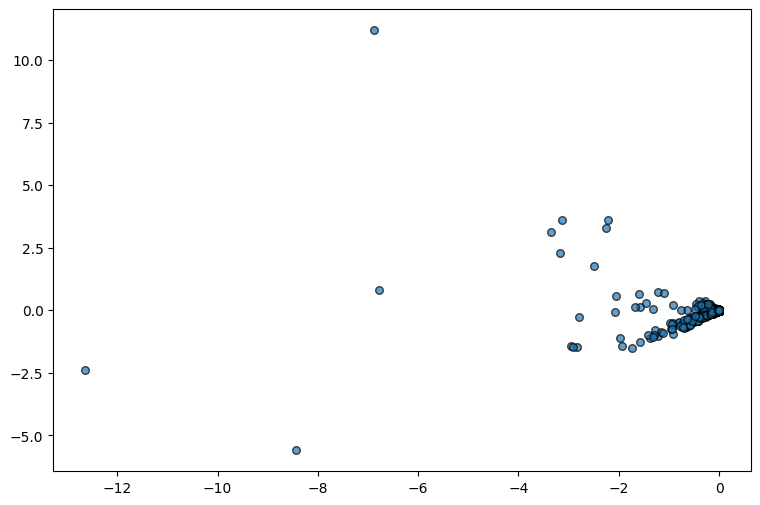

In [97]:
draw_2_dim()

## Доп ресурсы:

[13 сканов книг на кабильском](https://archive.org/details/booksbylanguage_kabui?tab=collection)

[Еще книги на кабильском](https://onlinebooks.library.upenn.edu/webbin/book/browse?type=lcsubc&key=Kabyle%20language%20--%20Dialects&c=x)

Возможно пригодится. 110 сканов книг на берберском (кабильский один из языков этой группы) на [archive.org](https://archive.org/details/texts?&and[]=languageSorter%3A%22Berber%22)